### <font color="green"> RNN and SVM Model for Stock prediction with only stock data</font>



**Import Libraries**

In [ ]:
#Import Libraries
import math
import time
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as prep
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import GRU
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get the Stock Data and Visualize** 

In [ ]:
#Fetch data from Yahoo finance 
df = web.DataReader('DIS', data_source='yahoo', start='2012-01-01', end='2019-12-31') 

#To get the stock data for companies Apple, Tesla, AMD and Disney uncomment the respective lines below
#df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#df = web.DataReader('AMD', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,38.459999,37.939999,37.970001,38.310001,9704200.0,34.300621
2012-01-04,38.990002,38.119999,38.189999,38.849998,9889900.0,34.784103
2012-01-05,39.580002,38.700001,38.830002,39.500000,14327100.0,35.366081
2012-01-06,40.150002,39.450001,39.549999,39.910000,14401600.0,35.733170
2012-01-09,40.250000,39.590000,39.740002,39.750000,12145200.0,35.589909


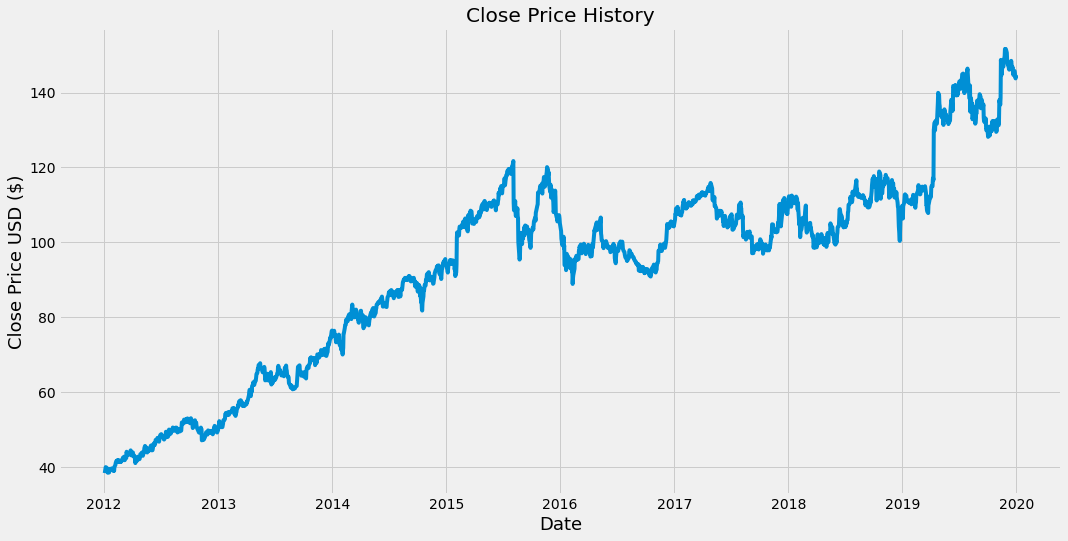

In [ ]:
#Visualizing the close price 
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Data Preprocessing**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Compute the number of rows to train the model
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Data sclaing using minmax scaler
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

**Trainig Data and Test Data with Window Size 60**

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
#Append the each training data with previous 60 Values
#These experements can repeated for multiple window size,
#for i in range(50,len(train_data)):
#for i in range(70,len(train_data)):
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#test_data = scaled_data[training_data_len: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
#Appending Test Data with previous 60 values
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
#Reshape the training and testig data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

**RNN**

In [ ]:
#Model creation
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another GRU layer
    model.add(GRU(units=512, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(GRU(units=256))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("linear"))

    start = time.time()
    # Setting model evaluation methods and optimizer
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
#Test and Train data shape
print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (1550, 60, 1)
y_train (1550,)
X_test (402, 60, 1)
y_test (402, 1)


In [ ]:
#Compiling the model
window = 60
model = build_model([1, window, 100, 1])

Compilation Time :  0.012555599212646484


In [ ]:
#Model training
model.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=1)

1550/1550 [==============================] - 297s 192ms/step - loss: 0.0060 - accuracy: 0.0000e+00


In [ ]:
#Test the train model using test data
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [ ]:
#Calculating rmse
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

3.6056766319387226

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


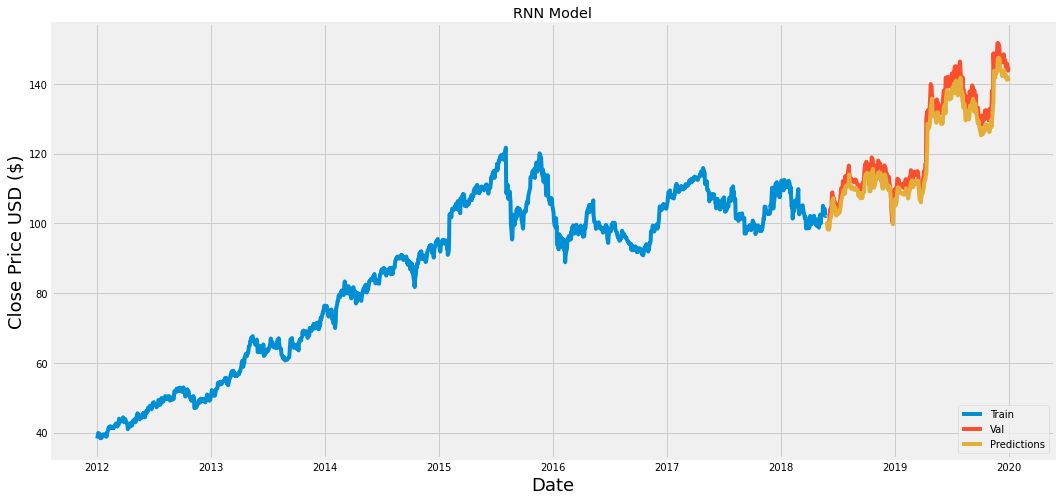

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('RNN Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

**RNN Model with batch processing**

In [ ]:
#Train Model with batch processing
model.fit(
    x_train,
    y_train,
    batch_size=50,
    epochs=50, verbose=1)

Epoch 1/50
31/31 [==============================] - 23s 732ms/step - loss: 0.0021 - accuracy: 0.0000e+00
Epoch 2/50
31/31 [==============================] - 23s 753ms/step - loss: 0.0020 - accuracy: 0.0000e+00
Epoch 3/50
31/31 [==============================] - 24s 789ms/step - loss: 0.0020 - accuracy: 0.0000e+00
Epoch 4/50
31/31 [==============================] - 25s 796ms/step - loss: 0.0020 - accuracy: 0.0000e+00
Epoch 5/50
31/31 [==============================] - 25s 792ms/step - loss: 0.0019 - accuracy: 0.0000e+00
Epoch 6/50
31/31 [==============================] - 24s 786ms/step - loss: 0.0017 - accuracy: 0.0000e+00
Epoch 7/50
31/31 [==============================] - 24s 781ms/step - loss: 0.0020 - accuracy: 0.0000e+00
Epoch 8/50
31/31 [==============================] - 24s 778ms/step - loss: 0.0014 - accuracy: 0.0000e+00
Epoch 9/50
31/31 [==============================] - 23s 758ms/step - loss: 0.0018 - accuracy: 0.0000e+00
Epoch 10/50
31/31 [==============================] - 23

In [ ]:
#Test the train model using test data
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)
#Calculating RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

2.595454827208569

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


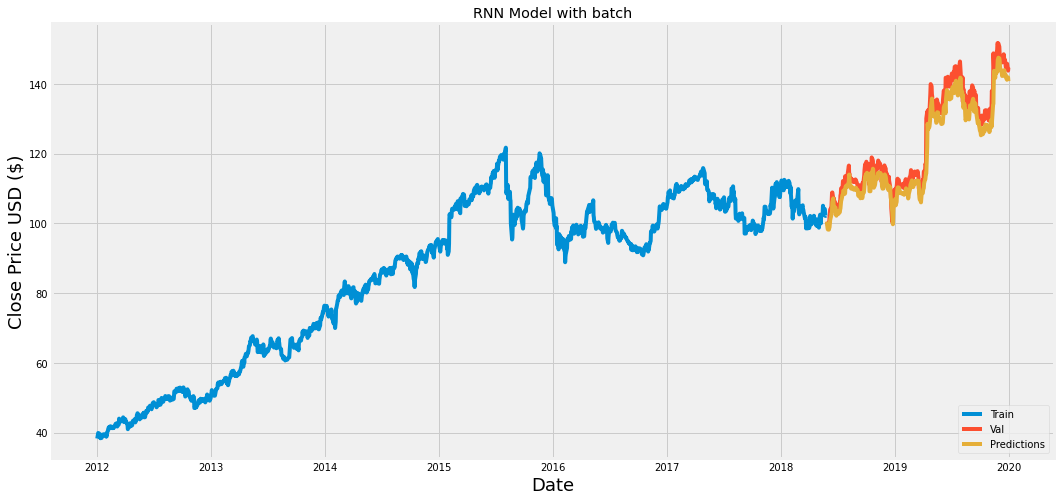

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('RNN Model with batch')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

**SVM**

In [ ]:
#Import SVM Library
from sklearn import svm

In [ ]:
#Reshape train data 
x_train_r=x_train.reshape(1550,60)

#Model creation
clf = svm.SVR()
#Model trainig
clf.fit(x_train_r, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
#Reshape test data
x_test_r=x_test.reshape(402,60)

#Test trained model
preds = clf.predict(x_test_r)
preds = preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)#Undo scaling
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

30.582736261859957

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


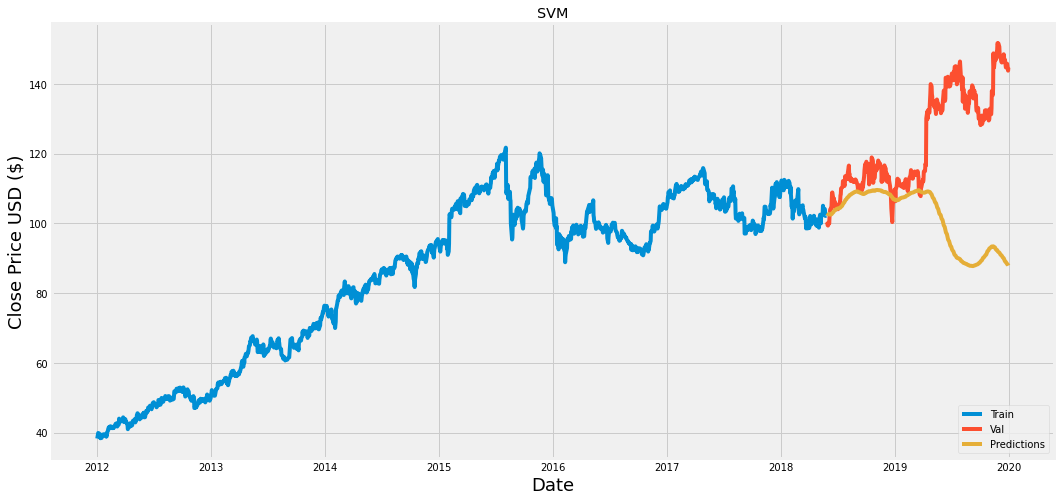

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('SVM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()